In [61]:
from selenium import webdriver
from time import sleep

skip = 0
player_lst = []
for i in range(10):
    url = f"https://api.tracker.gg/api/v1/valorant/standard/leaderboards?type=ranked&platform=pc&board=default&region=global&act=16118998-4705-5813-86dd-0292a2439d90&skip={skip}&take=100"

    driver_path = "/Users/kahunghe/Documents/GitHub/GE2324_GP9/chromedriver"
    driver = webdriver.Chrome(executable_path=driver_path)
    driver.get(url)
    skip += 100
    df = eval(driver.page_source.replace("""</pre><div class="json-formatter-container"></div></body></html>""","").replace("""<html><head><meta name="color-scheme" content="light dark"><meta charset="utf-8"></head><body><pre>""","").replace('null','None').replace('false','False').replace('true','True'))
    for i in df['data']['items']:
        player_lst.append(i['id'])
    sleep(10)
driver.quit()

with open('players.txt','w') as f:
    f.write(str(player_lst))

print(player_lst)

/var/folders/y4/_hfv_1c12c5dst33jlmwh_g80000gn/T/ipykernel_16671/587563936.py:10: DeprecationWarning: executable_path has been deprecated, please pass in a Service object
  driver = webdriver.Chrome(executable_path=driver_path)


['kupecc#111', 'myth#110', 'cg sp1ke#skk', 'ativik#qkw', 'traded#erica', 'pr0digyy#taduy', 'sharp#ugr', '有只笨笨小心#9411', 'kâi ru#ilah', 'verkozz#ak74', 'humblegod#1122', 'finessed#demon', '沖縄に行くために#1tab', 'derr#ddd', '14y old pegasus#2010', 'twitch notexxd#ktta', 'deth#ego', 'lagginglegend777#lvgod', 'nk clouq#444', 'mitrill#666', 'striker#aim', 'koshmarasuwu#gvibe', 'lni#0001', 'ucam yuno#pixi', 'mu geeza#caide', 'kiles#wrld', 'swissboy#rolex', '6ankai the f#矢吹丈', 't7xm4s#600hz', 'dvm sayonara#gud', 'diabloangle#euw', 'sr sarah#arf', 'fractioned#ssj', 'k z#vane', 'light#99115', 'envy eggsterr#njltc', 'binance user 1#usdt', 'la noia#feyza', 'mu chloric#tannr', 'simon#char', 'hell#g0d', 'kaniel outis#uyen', 'ffv kabzi#flow', 'dewü jnz#13y', 'noman#wazoo', 'roompa#yep', 'andy#0312', 'muddi#xyz', 'mzp shinnok#kiraj', 'minnie cardigan#lesly', 'g2 jawgemo#mor', 'mouz fizzy#fizz', 'rafe#efar', 'sp1xa#1337', 'in the dark#xxxx', 'siro#hqx', 'carmine#777', 'zeta hatto#0418', 'aus nx1#ssj', 'dre#p

In [62]:
len(player_lst)

1000

In [206]:

from random import randint
for player in player_lst[3:20]:
    try:
        #from player get all match id
        player = player.replace('#','%23')
        pages = 0

        match_id_lst = []
        for i in range(30):
            url = f"https://api.tracker.gg/api/v2/valorant/standard/matches/riot/{player}?type=competitive&season=&agent=all&map=all&next={pages}"

            driver_path = "/Users/kahunghe/Documents/GitHub/GE2324_GP9/chromedriver"
            driver = webdriver.Chrome(executable_path=driver_path)
            driver.get(url)
            pages+=1
            df = eval(driver.page_source.replace("""</pre><div class="json-formatter-container"></div></body></html>""","").replace("""<html><head><meta name="color-scheme" content="light dark"><meta charset="utf-8"></head><body><pre>""","").replace('null','None').replace('false','False').replace('true','True'))
            for j in df['data']['matches']:
                round_data = j['segments'][0]['stats']
                round_data_processed = {}
                for k in round_data:
                    round_data_processed = round_data_processed | {k:round_data[k]['value']}

                match_id_lst.append({"id":j['attributes']['id'],"map":j['attributes']['mapId']} |
                                    {'result':j['segments'][0]['metadata']['result']} |
                                    round_data_processed)
            
            

            sleep(randint(60,120))
        driver.quit()

        print(len(match_id_lst))
        #save to txt
        with open(f'matches/{player}_match_id.txt','w') as f:
            f.write(str(match_id_lst))
    except Exception as e:
        print(f"Error: {player}", e)
        sleep(120)
        continue

    


/var/folders/y4/_hfv_1c12c5dst33jlmwh_g80000gn/T/ipykernel_16671/2695882264.py:13: DeprecationWarning: executable_path has been deprecated, please pass in a Service object
  driver = webdriver.Chrome(executable_path=driver_path)


600
600
600
Error: sharp%23ugr 'data'
600
600
600
600
278
600
600
600


KeyboardInterrupt: 

In [202]:
match_id_lst

[{'id': 'a8e44247-bd39-465c-8ce2-90a1992d435c',
  'map': '/Game/Maps/Triad/Triad',
  'result': 'victory',
  'playtime': 2588,
  'roundsPlayed': 28,
  'roundsWon': 15,
  'roundsLost': 13,
  'roundsDisconnected': 0,
  'placement': 1,
  'score': 10300,
  'kills': 37,
  'deaths': 20,
  'assists': 4,
  'damage': 6766,
  'damageReceived': 4319,
  'headshots': 31,
  'grenadeCasts': 10,
  'ability1Casts': 12,
  'ability2Casts': 9,
  'ultimateCasts': 1,
  'dealtHeadshots': 31,
  'dealtBodyshots': 49,
  'dealtLegshots': 3,
  'econRating': 86,
  'suicides': 0,
  'revived': 1,
  'firstBloods': 8,
  'firstDeaths': 7,
  'lastDeaths': 3,
  'survived': 8,
  'traded': 3,
  'kasted': None,
  'kAST': 79.0,
  'flawless': 1,
  'thrifty': 0,
  'antiEco': None,
  'totalThrifty': None,
  'totalAntiEco': None,
  'manAdvantage': None,
  'manDisadvantage': None,
  'aces': 0,
  'teamAces': 0,
  'clutches': 1,
  'clutchesLost': 2,
  'plants': 0,
  'defuses': 0,
  'kdRatio': 1.85,
  'scorePerRound': 367.85714285714

In [161]:
map_set = set([i['map'] for i in match_id_lst])
map_set
    

{'/Game/Maps/Ascent/Ascent',
 '/Game/Maps/Bonsai/Bonsai',
 '/Game/Maps/Canyon/Canyon',
 '/Game/Maps/Duality/Duality',
 '/Game/Maps/Infinity/Infinity',
 '/Game/Maps/Jam/Jam',
 '/Game/Maps/Juliett/Juliett',
 '/Game/Maps/Pitt/Pitt',
 '/Game/Maps/Port/Port',
 '/Game/Maps/Triad/Triad'}

In [164]:

# match get match history test
import requests
from PIL import Image
from io import BytesIO
import matplotlib.pyplot as plt
import json

segments = []
target_map = [i['id'] for i in match_id_lst if i['map'] == list(map_set)[0]]#map_set[0] -> '/Game/Maps/Ascent/Ascent'
print(len(target_map))
for match_id in target_map:

    match_url = f"https://api.tracker.gg/api/v2/valorant/standard/matches/{match_id}"

    driver_path = "/Users/kahunghe/Documents/GitHub/GE2324_GP9/chromedriver"
    driver = webdriver.Chrome(executable_path=driver_path)
    driver.get(match_url)    
    sleep(5)
    #to dict
    match_test_df = json.loads(driver.page_source.replace("""</pre><div class="json-formatter-container"></div></body></html>""","").replace("""<html><head><meta name="color-scheme" content="light dark"><meta charset="utf-8"></head><body><pre>""",""))

    driver.quit()

    player_target = 'kupecc#111'
    segments += match_test_df["data"]["segments"]









51


/var/folders/y4/_hfv_1c12c5dst33jlmwh_g80000gn/T/ipykernel_16671/807626081.py:16: DeprecationWarning: executable_path has been deprecated, please pass in a Service object
  driver = webdriver.Chrome(executable_path=driver_path)


KeyError: 'platformUserIdentifier'

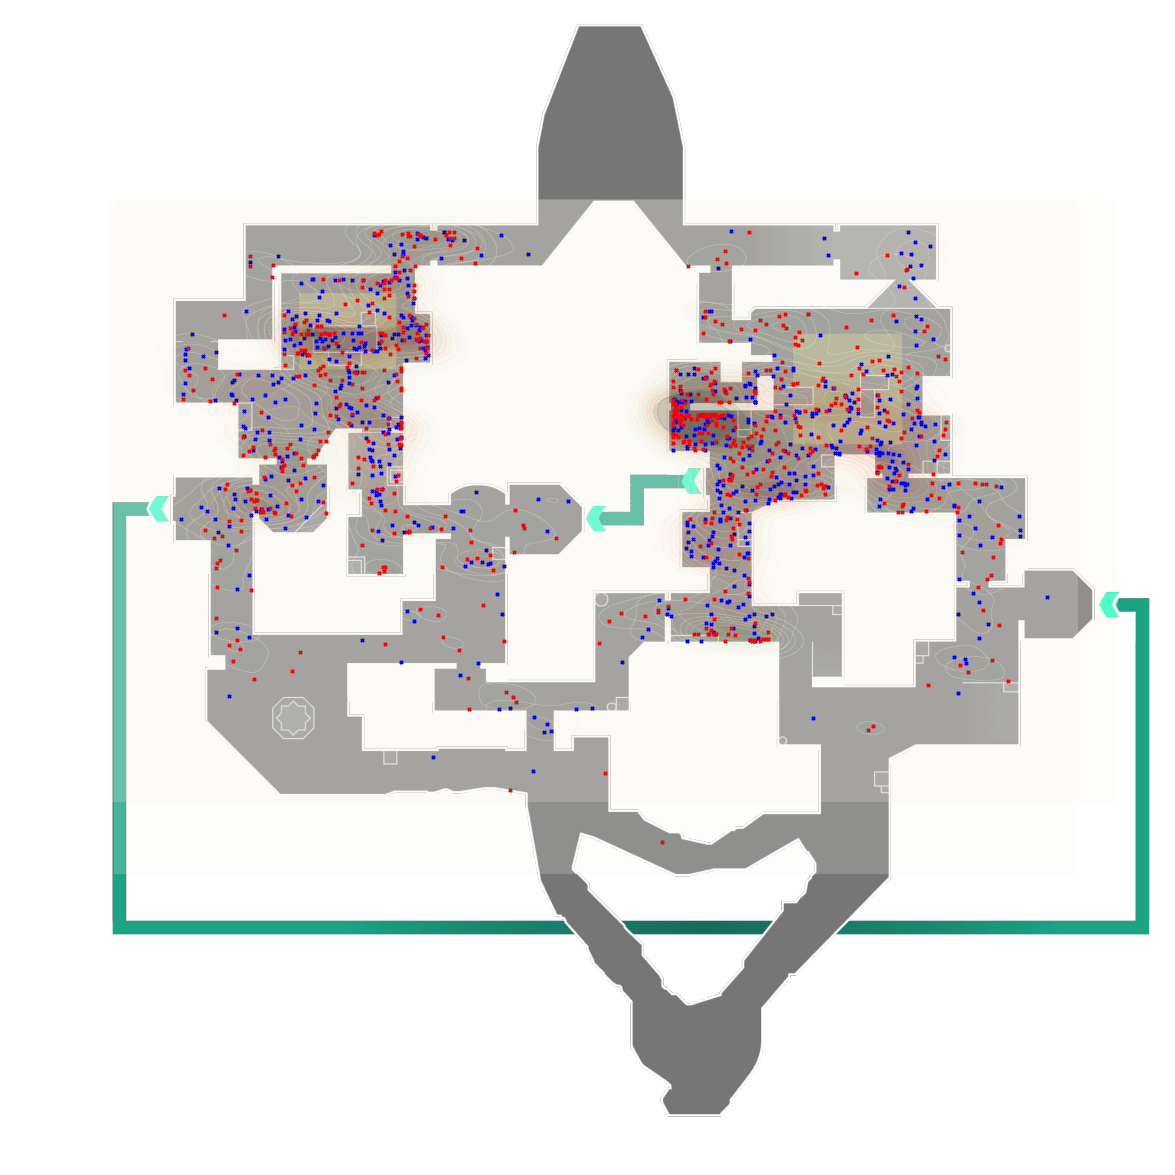

In [193]:

import seaborn as sns
import scipy
opponentLocations = []
killerLocations = []
for i in segments:
    if i['type'] == 'player-round-kills':
        killer = i['attributes']['platformUserIdentifier']
        if killer == player_target:
            if(i['metadata']['opponentLocation']['x']>200):
                opponentLocations.append(i['metadata']['opponentLocation'])

            
            for j in i['metadata']['playerLocations']:
                if(j['platformUserIdentifier'] == killer):
                    if(j['location']['x']>200):
                        killerLocations.append(j['location'])
        
map_img = match_test_df["data"]["metadata"]['mapDetails']['imageUrl']

response = requests.get(map_img)
image = Image.open(BytesIO(response.content))

xMultiplier = match_test_df["data"]["metadata"]['mapDetails']['xMultiplier']
yMultiplier = match_test_df["data"]["metadata"]['mapDetails']['yMultiplier']
xScalarToAdd = match_test_df["data"]["metadata"]['mapDetails']['xScalarToAdd']
yScalarToAdd = match_test_df["data"]["metadata"]['mapDetails']['yScalarToAdd']

points = [((i['y']),(i['x'])) for i in opponentLocations]
points_killer = [((i['y']),(i['x'])) for i in killerLocations]
                
image_width, image_height = image.size  # 获取图片尺寸
points_t = [
    (
        ((x * xMultiplier) + xScalarToAdd) * image_width,
        ((y * yMultiplier) + yScalarToAdd) * image_height
    )
    for x, y in points
]
points_killer_t = [
    (
        ((x * xMultiplier) + xScalarToAdd) * image_width,
        ((y * yMultiplier) + yScalarToAdd) * image_height
    )
    for x, y in points_killer
]
plt.figure(figsize=(15, 15))
w, h = image.size

plt.imshow(image)

# if len(points_t) > 0:
#     sns.kdeplot(
#         x=[i[0] for i in points_t], y=[i[1] for i in points_t], 
#         cmap="Reds", fill=True, alpha=0.2, thresh=0,bw_method = 0.1
#     )

if len(points_killer_t) > 0:
    sns.kdeplot(
        x=[i[0] for i in points_killer_t], y=[i[1] for i in points_killer_t], 
        cmap="Greens", fill=True, alpha=0.2, thresh=0,bw_method = 0.1
    )


#plt.scatter(*zip(*points_t), color='green', s=5, marker='x')
plt.scatter(*zip(*points_killer_t), color='red', s=5, marker='x')
plt.axis("off")
plt.show()